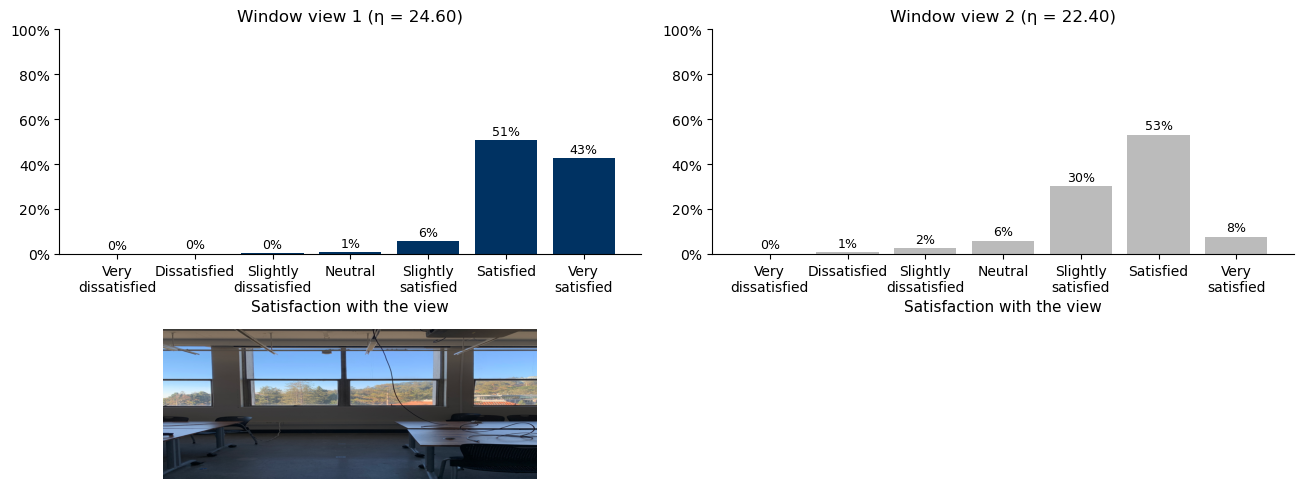

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.ticker import FuncFormatter
import matplotlib.image as mpimg
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk
from PIL import ImageGrab, Image

# ===== Constants and Config =====
BETA = [1.3972, 2.6791, 3.9682, 0.5856]
FENESTRATION_EFFECT = {"Blind up (Clear)": 2.1949, "Blind down": 0}
labels = [
    "Ratio of nature elements %",
    "Distance between object and glazing m",
    "Distance between observer and window m",
    "Horizontal view angle °",
    "Vertical view angle °"
]
ranges = [(0.09, 0.43), (3, 30), (0.9, 11), (5, 108), (14, 75)]
image_paths = [None, None]

def compute_eta(x1, x2, x3, x4, x5, fenestration_bias):
    x1_log = np.log(x1 + 1)
    x2_log = np.log(x2 + 1)
    x3_log = np.log(x3 + 1)
    x4_log = np.log(x4 + 1)
    x5_log = np.log(x5 + 1)
    x4_modified = x4_log * x5_log
    eta = BETA[0]*x1_log + BETA[1]*x2_log + BETA[2]*x3_log + BETA[3]*x4_modified + fenestration_bias
    return eta, x4_modified

def get_category_probabilities(eta):
    thresholds = np.array([15.535, 17.514, 18.973, 20.099, 21.967, 24.894])
    logistic = lambda x: 1 / (1 + np.exp(-x))
    cum_probs = logistic(thresholds - eta)
    probs = np.zeros(7)
    probs[0] = cum_probs[0]
    for i in range(1, 6):
        probs[i] = cum_probs[i] - cum_probs[i - 1]
    probs[6] = 1 - cum_probs[5]
    return probs

def capture_and_save_window(window, scale_factor=2):
    window.update()
    x = window.winfo_rootx()
    y = window.winfo_rooty()
    w = x + window.winfo_width()
    h = y + window.winfo_height()
    img = ImageGrab.grab(bbox=(x, y, w, h))
    img_high_res = img.resize((img.width * scale_factor, img.height * scale_factor), resample=Image.LANCZOS)
    path = filedialog.asksaveasfilename(defaultextension=".png",
        filetypes=[("PNG files", "*.png")], title="Save High-Resolution Screenshot")
    if path:
        img_high_res.save(path, dpi=(300, 300))

def upload_image(index):
    path = filedialog.askopenfilename(filetypes=[("Image files", "*.png *.jpg *.jpeg *.bmp")])
    if path:
        image_paths[index] = path

def copy_inputs(entry_groups):
    for i in range(len(entry_groups[0])):
        val = entry_groups[0][i].get()
        entry_groups[1][i].delete(0, tk.END)
        entry_groups[1][i].insert(0, val)

def run_gui():
    root = tk.Tk()
    root.title("View Quality Index (Enhanced UI)")
    root.geometry("1280x900")

    style = ttk.Style()
    style.theme_use("clam")
    style.configure("TButton", padding=6, font=("Segoe UI", 10), background="#00509e", foreground="white")
    style.map("TButton", background=[("active", "#0f75bc")])
    style.configure("TLabel", font=("Segoe UI", 10))
    style.configure("Header.TLabel", font=("Segoe UI", 16, "bold"), foreground="#0f75bc")
    style.configure("Section.TLabel", font=("Segoe UI", 12, "bold"))

    canvas = tk.Canvas(root, borderwidth=0, highlightthickness=0)
    scrollbar = tk.Scrollbar(root, orient="vertical", command=canvas.yview)
    scrollable_frame = ttk.Frame(canvas)
    scrollable_frame.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))
    canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
    canvas.configure(yscrollcommand=scrollbar.set)
    canvas.pack(side="left", fill="both", expand=True)
    scrollbar.pack(side="right", fill="y")
    canvas.bind_all("<MouseWheel>", lambda e: canvas.yview_scroll(int(-1*(e.delta/120)), "units"))

    for i in range(6):
        scrollable_frame.columnconfigure(i, weight=1, minsize=200)

    ttk.Label(scrollable_frame, text="Window View Quality Tool", style="Header.TLabel")\
        .grid(row=0, column=0, columnspan=6, pady=(10, 5), sticky="nsew")

    fenestration_vars = []
    entry_groups = [[], []]
    entry_widgets = [[None, None] for _ in range(len(labels))]

    for v, col in zip([1, 2], [0, 3]):
        ttk.Label(scrollable_frame, text=f"Window view #{v}", style="Section.TLabel")\
            .grid(row=1, column=col, columnspan=3, sticky="w", padx=10, pady=(10, 0))
        ttk.Label(scrollable_frame, text="Fenestration:")\
            .grid(row=2, column=col, sticky="e", padx=5)
        fen_var = tk.StringVar(value="Blind down")
        menu = ttk.OptionMenu(scrollable_frame, fen_var, fen_var.get(), *FENESTRATION_EFFECT.keys())
        menu.grid(row=2, column=col + 1, sticky="w", padx=5)
        fenestration_vars.append(fen_var)

    for i, (label, (rmin, rmax)) in enumerate(zip(labels, ranges)):
        r = 3 + i
        ttk.Label(scrollable_frame, text=label).grid(row=r, column=0, sticky="e", padx=5)
        entry1 = ttk.Entry(scrollable_frame, font=("Segoe UI", 10), width=14)
        entry1.insert(0, str(round((rmin + rmax)/2, 4)))
        entry1.grid(row=r, column=1, padx=5, pady=2, sticky="w")
        entry_groups[0].append(entry1)
        entry_widgets[i][0] = entry1

        ttk.Label(scrollable_frame, text=f"[{rmin:.2f}–{rmax:.2f}]", font=("Segoe UI", 9))\
            .grid(row=r, column=2, sticky="w")

        ttk.Label(scrollable_frame, text=label).grid(row=r, column=3, sticky="e", padx=5)
        entry2 = ttk.Entry(scrollable_frame, font=("Segoe UI", 10), width=14)
        entry2.insert(0, str(round((rmin + rmax)/2, 4)))
        entry2.grid(row=r, column=4, padx=5, pady=2, sticky="w")
        entry_groups[1].append(entry2)
        entry_widgets[i][1] = entry2

        def make_tab_callback(i=i, j=0):
            def on_tab(event):
                next_i = (i + 1) % len(entry_widgets)
                next_entry = entry_widgets[next_i][j]
                next_entry.focus_set()
                next_entry.select_range(0, 'end')
                next_entry.icursor('end')
                return "break"
            return on_tab

        entry1.bind("<Tab>", make_tab_callback(i, 0))
        entry2.bind("<Tab>", make_tab_callback(i, 1))
        entry1.bind("<FocusIn>", lambda e: (e.widget.select_range(0, 'end'), e.widget.icursor('end')))
        entry2.bind("<FocusIn>", lambda e: (e.widget.select_range(0, 'end'), e.widget.icursor('end')))

    ttk.Button(scrollable_frame, text="Upload image for view #1", command=lambda: upload_image(0))\
        .grid(row=10, column=1, pady=(5, 10), sticky="nsew")
    ttk.Button(scrollable_frame, text="Upload image for view #2", command=lambda: upload_image(1))\
        .grid(row=10, column=4, pady=(5, 10), sticky="nsew")
    ttk.Button(scrollable_frame, text="Copy from view #1 → #2", command=lambda: copy_inputs(entry_groups))\
        .grid(row=10, column=2, pady=(5, 10), sticky="nsew")

    def plot_dual(prob1, eta1, prob2, eta2):
        fig, axs = plt.subplots(2, 2, figsize=(12, 5), gridspec_kw={'height_ratios': [1.5, 1]})
        categories = [
            "Very\ndissatisfied", "Dissatisfied", "Slightly\ndissatisfied",
            "Neutral", "Slightly\nsatisfied", "Satisfied", "Very\nsatisfied"
        ]
        color1 = "#003262" if fenestration_vars[0].get() == "Blind up (Clear)" else "#BBBBBB"
        color2 = "#003262" if fenestration_vars[1].get() == "Blind up (Clear)" else "#BBBBBB"
        hatch2 = "" if color1 != color2 else "///"

        axs[0, 0].bar(categories, prob1, color=color1)
        axs[0, 0].set_title(f"Window view 1 (η = {eta1:.2f})", fontsize=12)
        axs[0, 1].bar(categories, prob2, color=color2, hatch=hatch2)
        axs[0, 1].set_title(f"Window view 2 (η = {eta2:.2f})", fontsize=12)

        for ax, probs in zip(axs[0], [prob1, prob2]):
            ax.set_ylim(0, 1)
            ax.set_yticks(np.arange(0, 1.1, 0.2))
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y * 100)}%"))
            for bar, prob in zip(ax.patches, probs):
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                        f"{int(round(prob * 100))}%", ha='center', va='bottom', fontsize=9)
            ax.set_xlabel("Satisfaction with the view", fontsize=11)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        for i in range(2):
            axs[1, i].clear()
            axs[1, i].axis("off")
            if image_paths[i]:
                try:
                    img = mpimg.imread(image_paths[i])
                    h, w = img.shape[:2]
                    aspect_ratio = h / w
                    image_width = 6 * 0.75
                    image_height = image_width * aspect_ratio
                    x_center = 3
                    x0 = x_center - image_width / 2
                    x1 = x_center + image_width / 2
                    axs[1, i].imshow(img, extent=[x0, x1, 0, image_height], aspect='auto')
                    axs[1, i].set_xlim(-0.5, 6.5)
                    axs[1, i].set_ylim(0, image_height)
                except Exception as e:
                    axs[1, i].text(0.5, 0.5, "Error loading image", ha="center", va="center")
        plt.tight_layout()
        return fig

    def on_submit():
        try:
            values = []
            for j in range(2):
                group = []
                for i, entry in enumerate(entry_groups[j]):
                    val = float(entry.get().strip())
                    rmin, rmax = ranges[i]
                    if not (rmin <= val <= rmax):
                        raise ValueError(f"Input {j+1} for '{labels[i]}' must be between {rmin} and {rmax}.")
                    group.append(val)
                values.append(group)
            eta1 = compute_eta(*values[0], FENESTRATION_EFFECT[fenestration_vars[0].get()])[0]
            eta2 = compute_eta(*values[1], FENESTRATION_EFFECT[fenestration_vars[1].get()])[0]
            prob1 = get_category_probabilities(eta1)
            prob2 = get_category_probabilities(eta2)
            fig = plot_dual(prob1, eta1, prob2, eta2)
            canvas_fig = FigureCanvasTkAgg(fig, master=scrollable_frame)
            canvas_widget = canvas_fig.get_tk_widget()
            canvas_widget.grid(row=100, column=0, columnspan=6, pady=(20, 10), sticky="nsew")
            canvas_fig.draw()
        except Exception as e:
            messagebox.showerror("Error", str(e))

    ttk.Button(scrollable_frame, text="Calculate and Plot", command=on_submit)\
        .grid(row=11, column=2, columnspan=1, pady=15, sticky="e")
    ttk.Button(scrollable_frame, text="Save entire window", command=lambda: capture_and_save_window(root, scale_factor=2))\
        .grid(row=11, column=3, columnspan=1, pady=15, sticky="w")

    root.mainloop()

if __name__ == "__main__":
    run_gui()